# Load Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
import math
import numpy as np
import pandas as pd
import random
import os

import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Data Collection Combining and Saving

### Setting directories

In [ ]:
train_data_dir = r"C:/Users/Ghost/Desktop/gits/Emotion-Based-Music-Recommendation/training/datasets/train/"
test_data_dir = r"C:/Users/Ghost/Desktop/gits/Emotion-Based-Music-Recommendation/training/datasets/test/"

### Collect images from each train and test dataset and save it into a numpy array

In [ ]:
def collect_data(directory):
    data = []
    labels = []

    total = 0

    for index, label  in enumerate(os.listdir(directory)):

        for image_file in os.listdir(os.path.join(directory, label)):

            img = cv2.imread(os.path.join(os.path.join(directory, label, image_file)))

            data.append(img)
            labels.append(label)

            total += 1

    print(f'Total data saved = {total}')
    return data,labels

In [ ]:
final_data = []
final_labels = []

# Getting train_datas
print("Train Datas")

train_data, train_labels = collect_data(train_data_dir)
final_data.extend(train_data)
final_labels.extend(train_labels)

# Getting test_datas
print("Test Datas")

test_data, test_labels = collect_data(test_data_dir)
final_data.extend(test_data)
final_labels.extend(test_labels)


Train Datas
Total data saved = 28709
Test Datas
Total data saved = 7178


### Shuffle


In [ ]:
combined_list = list(zip(final_data,final_labels))
shuffled_combined_list = random.sample(combined_list,len(combined_list))

final_data,final_labels = zip(*shuffled_combined_list)

In [ ]:
data = np.array(final_data)
labels = np.array(final_labels)

### Saving to .npy file so we can load datasets later

In [ ]:
np.save("emotion_data.npy",data)
np.save("emotion_labels.npy",labels)

In [20]:
data = np.load('/content/drive/MyDrive/fuse/emotion_data.npy')
labels = np.load('/content/drive/MyDrive/fuse/emotion_labels.npy')

# Visualization

### Visualizing Labels

In [21]:
categories = ['angry','disgust','fear','happy','neutral','sad','surprise']

Total Number of Images : 35887


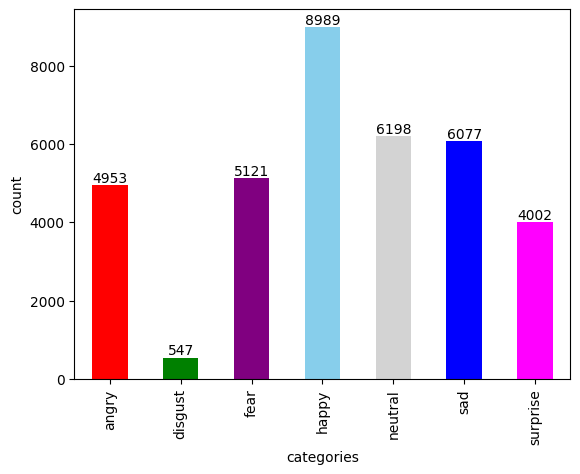

In [22]:
# Total Numer of Images
print(f"Total Number of Images : {len(labels)}")

# For coloring purposes
color_map = {'angry' : 'red','disgust' : 'green','fear' : 'purple','happy' : 'skyblue','neutral' : 'lightgray','sad' : 'blue','surprise' : 'magenta'}

# Plotting bar graph
label_series = pd.Series(labels)
ax = label_series.value_counts().sort_index(ascending=True).plot(kind="bar",color=[color_map[x] for x in categories],xlabel='categories',ylabel='count');

for bar in ax.patches:
    ax.annotate(str(bar.get_height()), (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='bottom')


### Visualizing Images

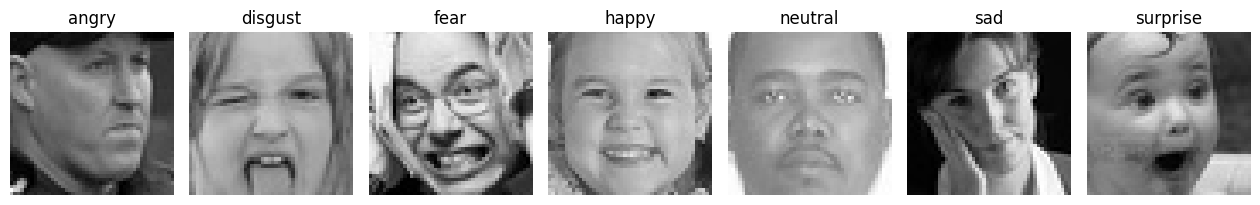

In [23]:
def random_value_for_index(list, target_value):
    indices = [index for index,value in enumerate(list) if value == target_value]
    return random.choice(indices)

fig, axs = plt.subplots(1,7 ,figsize=(16,16))

for index,category in enumerate(categories):
    # Select random image index from specific category
    random_index = random_value_for_index(labels,category)

    # Plot the random image
    axs[index].imshow(data[random_index])
    axs[index].axis('off')
    axs[index].set_title(category)

plt.subplots_adjust(wspace = 0.1,hspace = 0.1)
plt.show()

# Training

### Split the data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=41)

In [25]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [26]:
# Assuming X_train contains your input images as uint8 (shape: [num_samples, height, width, channels])
X_train = X_train / 255.0
X_test = X_test / 255.0

In [27]:
# Access the classes and their corresponding encoded numbers
classes_and_labels = dict(
    zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
class_labels = {}
# Print the result
print("Encoded Labels:")
for label, encoded_number in classes_and_labels.items():
    print(f"{label} is encoded as {encoded_number}")
    class_labels[label] = encoded_number
print(class_labels)

Encoded Labels:
angry is encoded as 0
disgust is encoded as 1
fear is encoded as 2
happy is encoded as 3
neutral is encoded as 4
sad is encoded as 5
surprise is encoded as 6
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [28]:
class CNNModel(Layer):
    def __init__(self, out_channels, kernel_size=3):
        super(CNNModel, self).__init__()
        self.conv = Conv2D(out_channels, kernel_size, padding="same")
        self.bn = BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        return x


class ResBlock(Layer):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.cnn1 = CNNModel(channels[0])
        self.cnn2 = CNNModel(channels[1])
        self.cnn3 = CNNModel(channels[2])
        self.pooling = MaxPooling2D()
        self.identity_mapping = Conv2D(channels[1], 3, padding="same")

    def call(self, input_tensor, training=False):
        x = self.cnn1(input_tensor, training=training)
        x = self.cnn2(x, training=training)
        x = self.cnn3(x + self.identity_mapping(input_tensor),
                      training=training)
        return self.pooling(x)


class ResNet_Like(Model):
    def __init__(self, num_classes):
        super(ResNet_Like, self).__init__()
        self.block1 = ResBlock([32, 32, 64])
        self.block2 = ResBlock([128, 128, 256])
        self.block3 = ResBlock([128, 256, 512])
        self.pool = GlobalAveragePooling2D()
        self.classifier = Dense(num_classes)

    def call(self, input_tensor, training=False):
        x = self.block1(input_tensor, training=training)
        x = self.block2(x, training=training)
        x = self.block3(x, training=training)
        x = self.pool(x)
        return self.classifier(x)

    def model(self):
        x = tf.keras.Input(shape=(48, 48, 3))
        return Model(inputs=[x], outputs=self.call(x))


model = ResNet_Like(num_classes=len(np.unique(labels)))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


model.model().summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 res_block_3 (ResBlock)      (None, 24, 24, 64)        30048     
                                                                 
 res_block_4 (ResBlock)      (None, 12, 12, 256)       592512    
                                                                 
 res_block_5 (ResBlock)      (None, 6, 6, 512)         2364032   
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                           

In [29]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1,callbacks=[callback])


Epoch 1/100
404/404 [==============================] - 36s 69ms/step - loss: 1.6273 - accuracy: 0.3556 - val_loss: 1.9996 - val_accuracy: 0.1762
Epoch 2/100
404/404 [==============================] - 26s 65ms/step - loss: 1.3076 - accuracy: 0.5021 - val_loss: 1.8015 - val_accuracy: 0.3434
Epoch 3/100
404/404 [==============================] - 26s 64ms/step - loss: 1.1788 - accuracy: 0.5544 - val_loss: 1.5952 - val_accuracy: 0.4399
Epoch 4/100
404/404 [==============================] - 27s 67ms/step - loss: 1.0978 - accuracy: 0.5845 - val_loss: 2.4161 - val_accuracy: 0.2132
Epoch 5/100
404/404 [==============================] - 26s 65ms/step - loss: 1.0335 - accuracy: 0.6124 - val_loss: 1.6535 - val_accuracy: 0.4758
Epoch 6/100
404/404 [==============================] - 27s 66ms/step - loss: 0.9671 - accuracy: 0.6374 - val_loss: 2.2514 - val_accuracy: 0.3699
Epoch 7/100
404/404 [==============================] - 26s 65ms/step - loss: 0.9078 - accuracy: 0.6622 - val_loss: 1.5624 - val_ac

# Save model

In [15]:
# model.save('models/emotion_saved_model', save_format='h5')

# Save Logs

In [31]:
# Create a DataFrame from the history object
history_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
history_df.to_csv('training_history.csv', index=False)

# Training Metrics

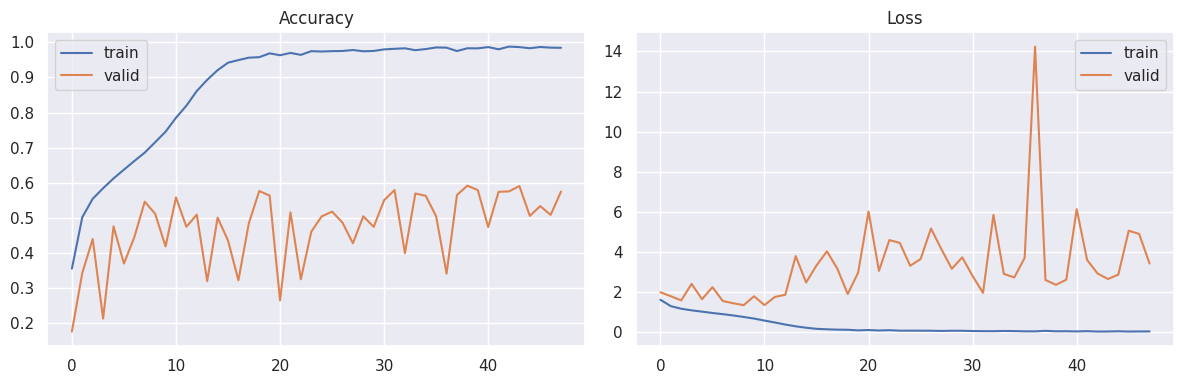

In [33]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

# plt.savefig('epoch_history_dcnn.png')
plt.show()

In [39]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

225/225 [==============================] - 4s 14ms/step


# Evaluation Metrics

In [41]:

report = classification_report(y_test, y_pred_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

       angry       0.62      0.33      0.43       961
     disgust       0.93      0.26      0.41       108
        fear       0.68      0.13      0.22      1005
       happy       0.87      0.72      0.79      1819
     neutral       0.63      0.39      0.48      1252
         sad       0.33      0.88      0.48      1250
    surprise       0.70      0.77      0.74       783

    accuracy                           0.55      7178
   macro avg       0.68      0.50      0.51      7178
weighted avg       0.66      0.55      0.54      7178



<Axes: >

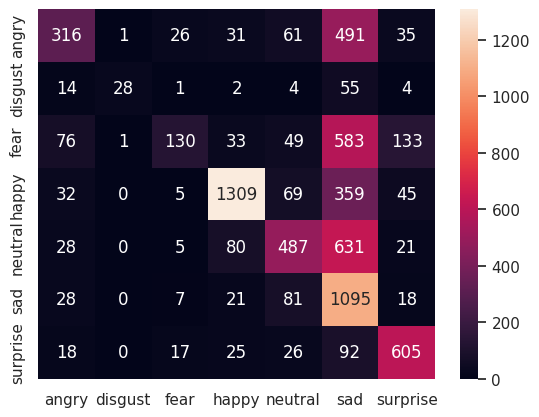

In [45]:
cf_matrix = confusion_matrix(y_test, y_pred_classes)
cm_array_df = pd.DataFrame(cf_matrix, index=categories, columns=categories)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12},fmt=".0f")